In [ ]:
# code is taken from https://www.kaggle.com/code/killa92/waste-image-data-analysis-classification

import os, torch, shutil, numpy as np
from glob import glob; from PIL import Image
from torch.utils.data import random_split, Dataset, DataLoader
from torchvision import transforms as T
torch.manual_seed(2024)

class CustomDataset(Dataset):

    def __init__(self, root, transformations = None):

        self.transformations = transformations
        self.im_paths = [im_path for im_path in sorted(glob(f"{root}/*/*"))]

        self.cls_names, self.cls_counts, count, data_count = {}, {}, 0, 0
        for idx, im_path in enumerate(self.im_paths):
            class_name = self.get_class(im_path)
            if class_name not in self.cls_names: self.cls_names[class_name] = count; self.cls_counts[class_name] = 1; count += 1
            else: self.cls_counts[class_name] += 1

    def get_class(self, path): return os.path.dirname(path).split("/")[-1]

    def __len__(self): return len(self.im_paths)

    def __getitem__(self, idx):

        im_path = self.im_paths[idx]
        im = Image.open(im_path).convert("RGB")
        gt = self.cls_names[self.get_class(im_path)]

        if self.transformations is not None: im = self.transformations(im)

        return im, gt

def get_dls(root, transformations, bs, split = [0.9, 0.05, 0.05], ns = 4):

    ds = CustomDataset(root = root, transformations = transformations)

    total_len = len(ds)
    tr_len = int(total_len * split[0])
    vl_len = int(total_len * split[1])
    ts_len = total_len - (tr_len + vl_len)

    tr_ds, vl_ds, ts_ds = random_split(dataset = ds, lengths = [tr_len, vl_len, ts_len])

    tr_dl, val_dl, ts_dl = DataLoader(tr_ds, batch_size = bs, shuffle = True, num_workers = ns), DataLoader(vl_ds, batch_size = bs, shuffle = False, num_workers = ns), DataLoader(ts_ds, batch_size = 1, shuffle = False, num_workers = ns)

    return tr_dl, val_dl, ts_dl, ds.cls_names

root = "/content/drive/MyDrive/realwaste-main/RealWaste"
mean, std, random_im_size, im_size = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225], 256, 224
tfs = T.Compose([T.RandomResizedCrop((random_im_size, random_im_size)), T.CenterCrop((im_size, im_size)), T.RandomHorizontalFlip(), T.ToTensor(), T.Normalize(mean = mean, std = std)])
tr_dl, val_dl, ts_dl, classes = get_dls(root = root, transformations = tfs, bs = 32)

print(len(tr_dl)); print(len(val_dl)); print(len(ts_dl)); print(classes)

134
8
239
{'Cardboard': 0, 'Food Organics': 1, 'Glass': 2, 'Metal': 3, 'Miscellaneous Trash': 4, 'Paper': 5, 'Plastic': 6, 'Textile Trash': 7, 'Vegetation': 8}


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


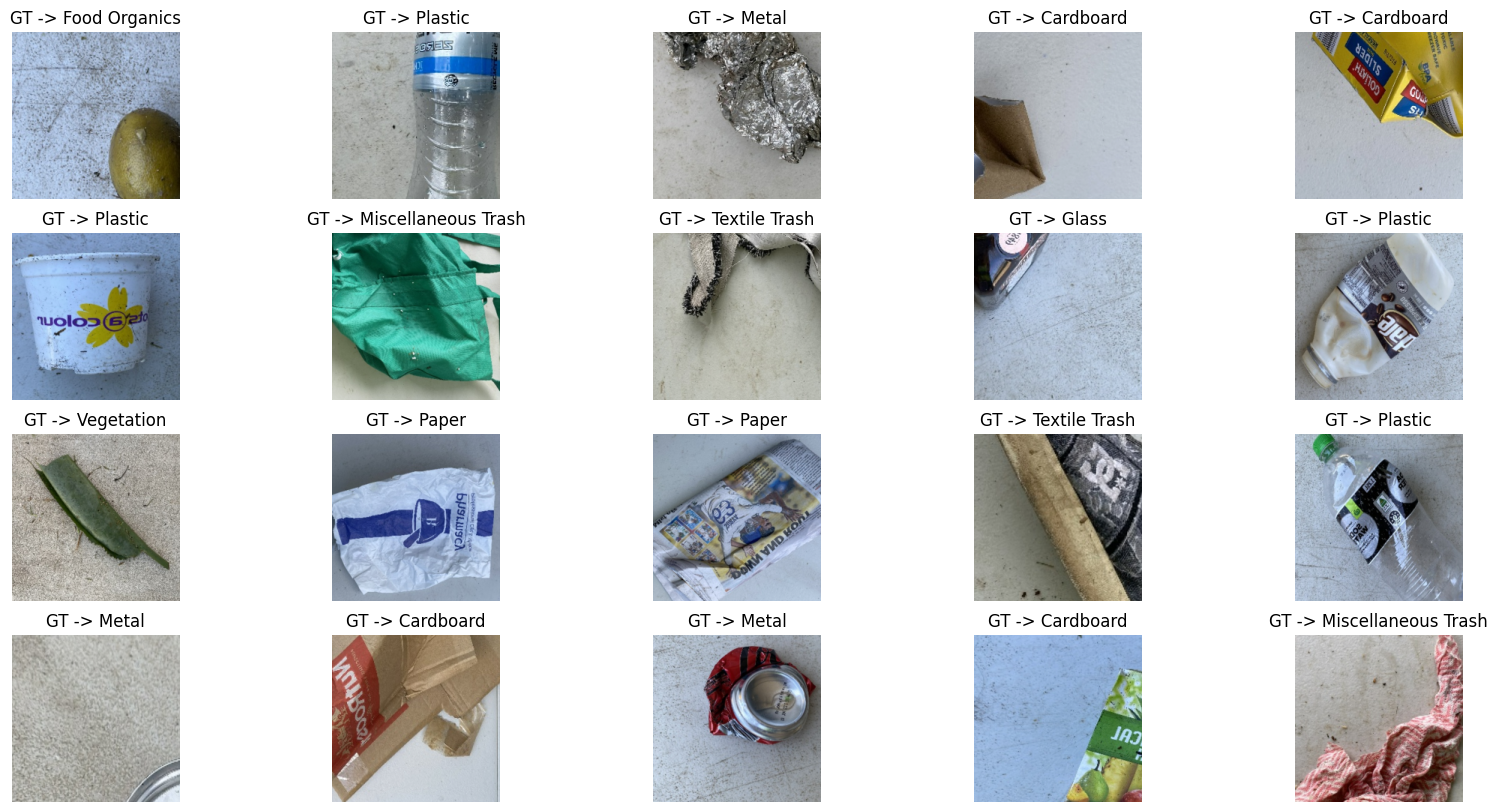

In [ ]:
import random
from matplotlib import pyplot as plt

def tensor_2_im(t, t_type = "rgb"):

    gray_tfs = T.Compose([T.Normalize(mean = [ 0.], std = [1/0.5]), T.Normalize(mean = [-0.5], std = [1])])
    rgb_tfs = T.Compose([T.Normalize(mean = [ 0., 0., 0. ], std = [ 1/0.229, 1/0.224, 1/0.225 ]), T.Normalize(mean = [ -0.485, -0.456, -0.406 ], std = [ 1., 1., 1. ])])

    invTrans = gray_tfs if t_type == "gray" else rgb_tfs

    return (invTrans(t) * 255).detach().squeeze().cpu().permute(1,2,0).numpy().astype(np.uint8) if t_type == "gray" else (invTrans(t) * 255).detach().cpu().permute(1,2,0).numpy().astype(np.uint8)

def visualize(data, n_ims, rows, cmap = None, cls_names = None):

    assert cmap in ["rgb", "gray"], "Rasmni oq-qora yoki rangli ekanini aniqlashtirib bering!"
    if cmap == "rgb": cmap = "viridis"

    plt.figure(figsize = (20, 10))
    indekslar = [random.randint(0, len(data) - 1) for _ in range(n_ims)]
    for idx, indeks in enumerate(indekslar):

        im, gt = data[indeks]
        # Start plot
        plt.subplot(rows, n_ims // rows, idx + 1)
        if cmap: plt.imshow(tensor_2_im(im, cmap), cmap=cmap)
        else: plt.imshow(tensor_2_im(im))
        plt.axis('off')
        if cls_names is not None: plt.title(f"GT -> {cls_names[int(gt)]}")
        else: plt.title(f"GT -> {gt}")

visualize(tr_dl.dataset, 20, 4, "rgb", list(classes.keys()))

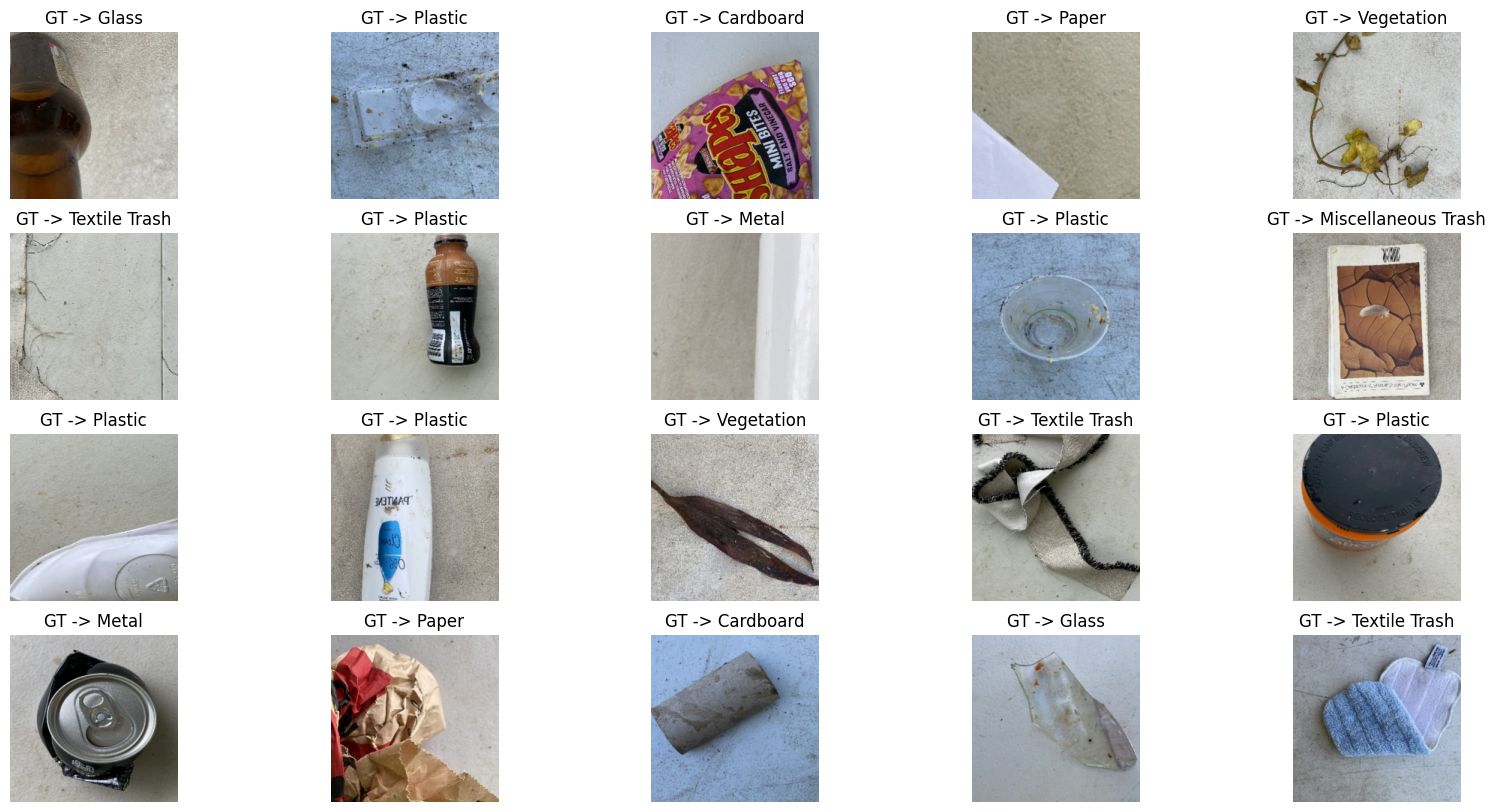

In [ ]:
visualize(val_dl.dataset, 20, 4, "rgb", list(classes.keys()))

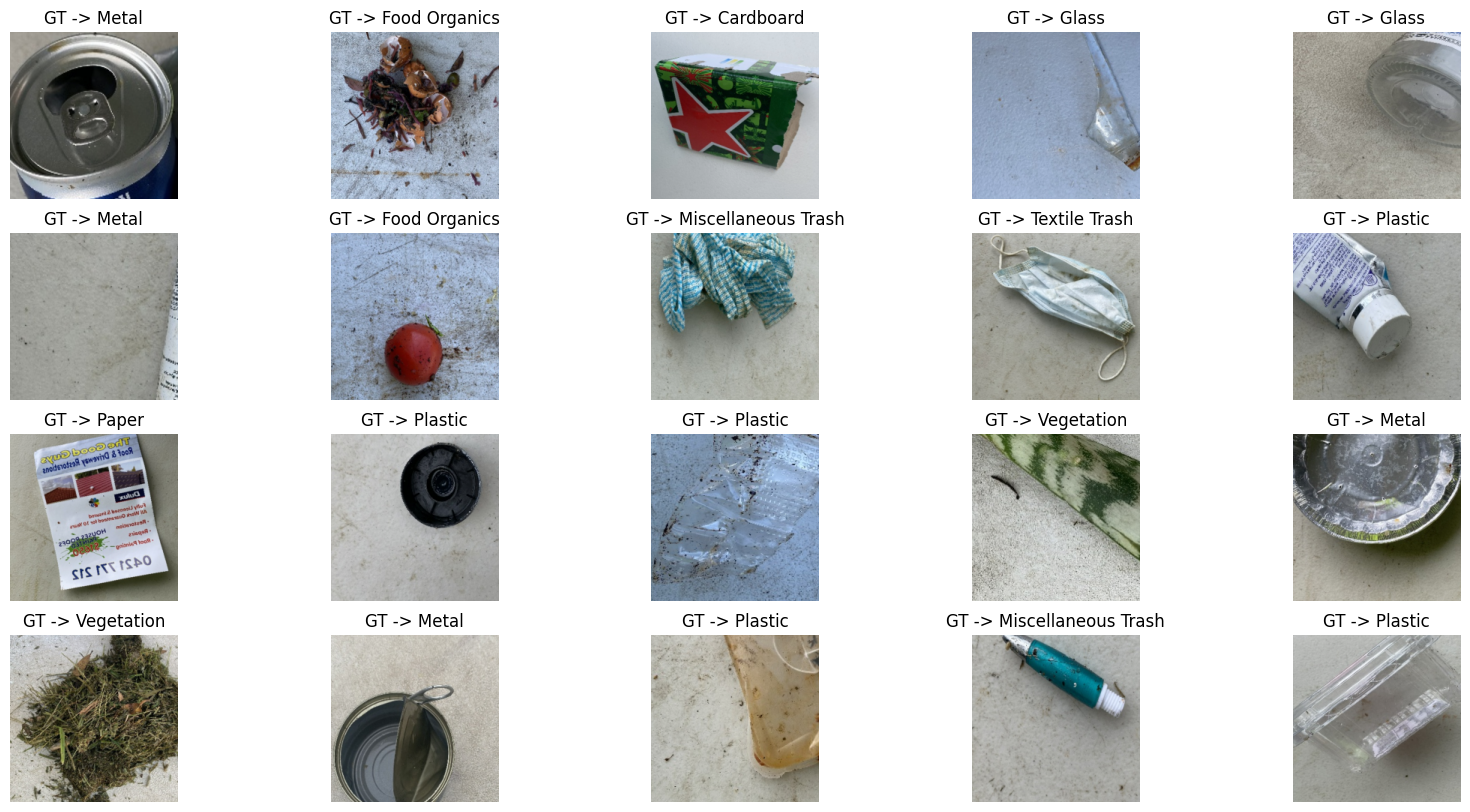

In [ ]:
visualize(ts_dl.dataset, 20, 4, "rgb", list(classes.keys()))

<ipython-input-7-89b0e37fe94c>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(cls_names, rotation = 60)


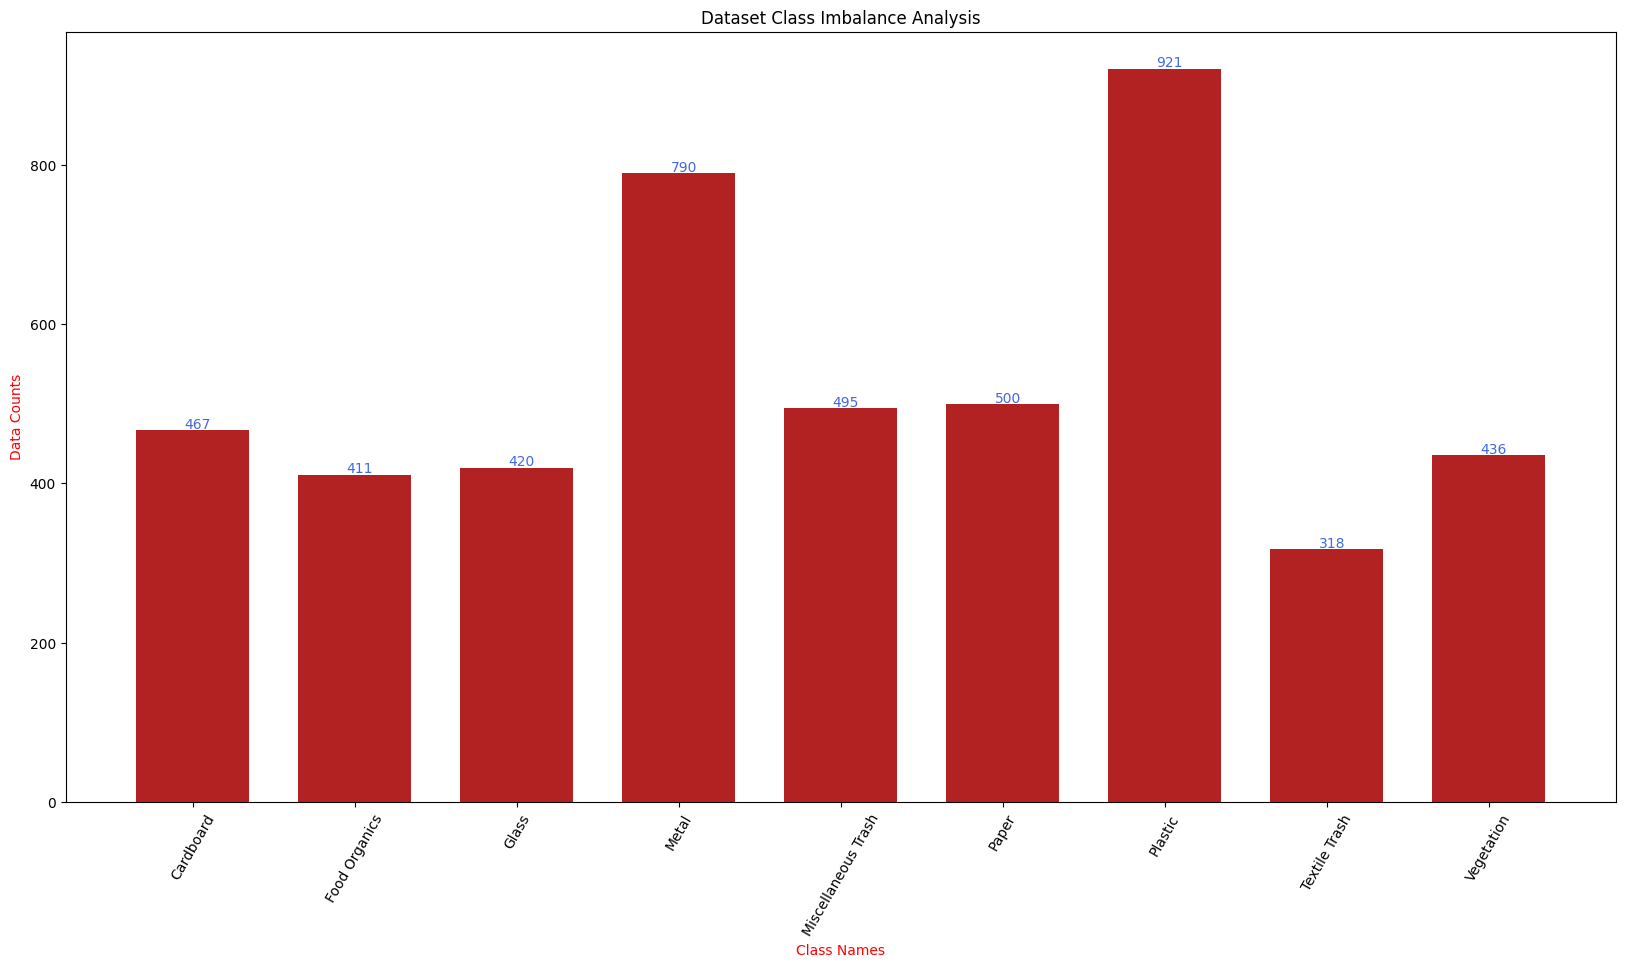

In [ ]:
def data_analysis(root, transformations):

    ds = CustomDataset(root = root, transformations = transformations)
    cls_counts, width, text_width = ds.cls_counts,  0.7, 0.05
    text_height = 2
    cls_names = list(cls_counts.keys()); counts = list(cls_counts.values())

    fig, ax = plt.subplots(figsize = (20, 10))
    indices = np.arange(len(counts))

    ax.bar(indices, counts, width, color = "firebrick")
    ax.set_xlabel("Class Names", color = "red")
    ax.set_xticklabels(cls_names, rotation = 60)
    ax.set(xticks = indices, xticklabels = cls_names)
    ax.set_ylabel("Data Counts", color = "red")
    ax.set_title(f"Dataset Class Imbalance Analysis")

    for i, v in enumerate(counts): ax.text(i - text_width, v + text_height, str(v), color = "royalblue")

data_analysis(root = root, transformations = tfs)

In [ ]:
import timm
from tqdm import tqdm
m = timm.create_model("rexnet_150", pretrained = True, num_classes = len(classes))
def train_setup(m): return m.to("cuda").eval(), 15, "cuda", torch.nn.CrossEntropyLoss(), torch.optim.Adam(params = m.parameters(), lr = 3e-4)
def to_device(batch, device): return batch[0].to(device), batch[1].to(device)
def get_metrics(model, ims, gts, loss_fn, epoch_loss, epoch_acc): preds = model(ims); loss = loss_fn(preds, gts); return loss, epoch_loss + (loss.item()), epoch_acc + (torch.argmax(preds, dim = 1) == gts).sum().item()

m, epochs, device, loss_fn, optimizer = train_setup(m)

save_prefix, save_dir = "waste", "saved_models"
print("Start training...")
best_acc, best_loss, threshold, not_improved, patience = 0, float("inf"), 0.01, 0, 5
tr_losses, val_losses, tr_accs, val_accs = [], [], [], []

best_loss = float(torch.inf)

for epoch in range(epochs):

    epoch_loss, epoch_acc = 0, 0
    for idx, batch in tqdm(enumerate(tr_dl)):

        ims, gts = to_device(batch, device)

        loss, epoch_loss, epoch_acc = get_metrics(m, ims, gts, loss_fn, epoch_loss, epoch_acc)
        optimizer.zero_grad(); loss.backward(); optimizer.step()

    tr_loss_to_track = epoch_loss / len(tr_dl)
    tr_acc_to_track  = epoch_acc / len(tr_dl.dataset)
    tr_losses.append(tr_loss_to_track); tr_accs.append(tr_acc_to_track)

    print(f"{epoch + 1}-epoch train process is completed!")
    print(f"{epoch + 1}-epoch train loss          -> {tr_loss_to_track:.3f}")
    print(f"{epoch + 1}-epoch train accuracy      -> {tr_acc_to_track:.3f}")

    m.eval()
    with torch.no_grad():
        val_epoch_loss, val_epoch_acc = 0, 0
        for idx, batch in enumerate(val_dl):
            ims, gts = batch
            ims, gts = ims.to(device), gts.to(device)

            preds = m(ims)
            loss = loss_fn(preds, gts)
            pred_cls = torch.argmax(preds.data, dim = 1)
            val_epoch_acc += (pred_cls == gts).sum().item()
            val_epoch_loss += loss.item()

        val_loss_to_track = val_epoch_loss / len(val_dl)
        val_acc_to_track  = val_epoch_acc / len(val_dl.dataset)
        val_losses.append(val_loss_to_track); val_accs.append(val_acc_to_track)

        print(f"{epoch + 1}-epoch validation process is completed!")
        print(f"{epoch + 1}-epoch validation loss     -> {val_loss_to_track:.3f}")
        print(f"{epoch + 1}-epoch validation accuracy -> {val_acc_to_track:.3f}")

        if val_loss_to_track < (best_loss + threshold):
            os.makedirs(save_dir, exist_ok = True)
            best_loss = val_loss_to_track
            torch.save(m.state_dict(), f"{save_dir}/{save_prefix}_best_model.pth")

        else:
            not_improved += 1
            print(f"Loss value did not decrease for {not_improved} epochs")
            if not_improved == patience:
                print(f"Stop training since loss value did not decrease for {patience} epochs.")
                break

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/39.2M [00:00<?, ?B/s]

Start training...


134it [05:44,  2.57s/it]

1-epoch train process is completed!
1-epoch train loss          -> 1.147
1-epoch train accuracy      -> 0.613


1-epoch validation process is completed!
1-epoch validation loss     -> 0.619
1-epoch validation accuracy -> 0.789


134it [00:38,  3.46it/s]

2-epoch train process is completed!
2-epoch train loss          -> 0.652
2-epoch train accuracy      -> 0.770


2-epoch validation process is completed!
2-epoch validation loss     -> 0.508
2-epoch validation accuracy -> 0.819


134it [00:38,  3.48it/s]

3-epoch train process is completed!
3-epoch train loss          -> 0.478
3-epoch train accuracy      -> 0.833


3-epoch validation process is completed!
3-epoch validation loss     -> 0.468
3-epoch validation accuracy -> 0.840


134it [00:38,  3.46it/s]

4-epoch train process is completed!
4-epoch train loss          -> 0.421
4-epoch train accuracy      -> 0.851


4-epoch validation process is completed!
4-epoch validation loss     -> 0.390
4-epoch validation accuracy -> 0.869


134it [00:39,  3.43it/s]

5-epoch train process is completed!
5-epoch train loss          -> 0.351
5-epoch train accuracy      -> 0.883


5-epoch validation process is completed!
5-epoch validation loss     -> 0.429
5-epoch validation accuracy -> 0.857
Loss value did not decrease for 1 epochs


134it [00:38,  3.49it/s]

6-epoch train process is completed!
6-epoch train loss          -> 0.324
6-epoch train accuracy      -> 0.883


6-epoch validation process is completed!
6-epoch validation loss     -> 0.334
6-epoch validation accuracy -> 0.869


134it [00:38,  3.45it/s]

7-epoch train process is completed!
7-epoch train loss          -> 0.269
7-epoch train accuracy      -> 0.909


7-epoch validation process is completed!
7-epoch validation loss     -> 0.536
7-epoch validation accuracy -> 0.827
Loss value did not decrease for 2 epochs


134it [00:39,  3.38it/s]

8-epoch train process is completed!
8-epoch train loss          -> 0.250
8-epoch train accuracy      -> 0.915


8-epoch validation process is completed!
8-epoch validation loss     -> 0.462
8-epoch validation accuracy -> 0.844
Loss value did not decrease for 3 epochs


134it [00:39,  3.39it/s]

9-epoch train process is completed!
9-epoch train loss          -> 0.235
9-epoch train accuracy      -> 0.923


9-epoch validation process is completed!
9-epoch validation loss     -> 0.292
9-epoch validation accuracy -> 0.882


134it [00:39,  3.37it/s]

10-epoch train process is completed!
10-epoch train loss          -> 0.208
10-epoch train accuracy      -> 0.925


10-epoch validation process is completed!
10-epoch validation loss     -> 0.292
10-epoch validation accuracy -> 0.907


134it [00:39,  3.40it/s]

11-epoch train process is completed!
11-epoch train loss          -> 0.190
11-epoch train accuracy      -> 0.938


11-epoch validation process is completed!
11-epoch validation loss     -> 0.400
11-epoch validation accuracy -> 0.857
Loss value did not decrease for 4 epochs


134it [00:39,  3.41it/s]

12-epoch train process is completed!
12-epoch train loss          -> 0.172
12-epoch train accuracy      -> 0.938


12-epoch validation process is completed!
12-epoch validation loss     -> 0.379
12-epoch validation accuracy -> 0.882
Loss value did not decrease for 5 epochs
Stop training since loss value did not decrease for 5 epochs.


In [ ]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 10.8 MB/s eta 0:00:00


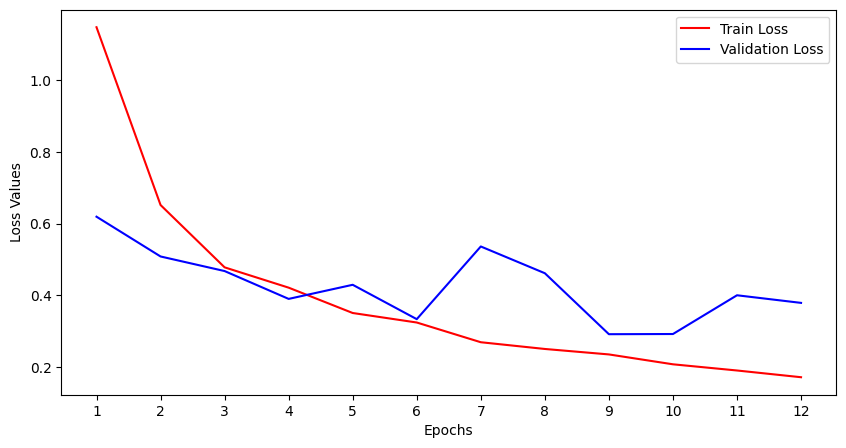

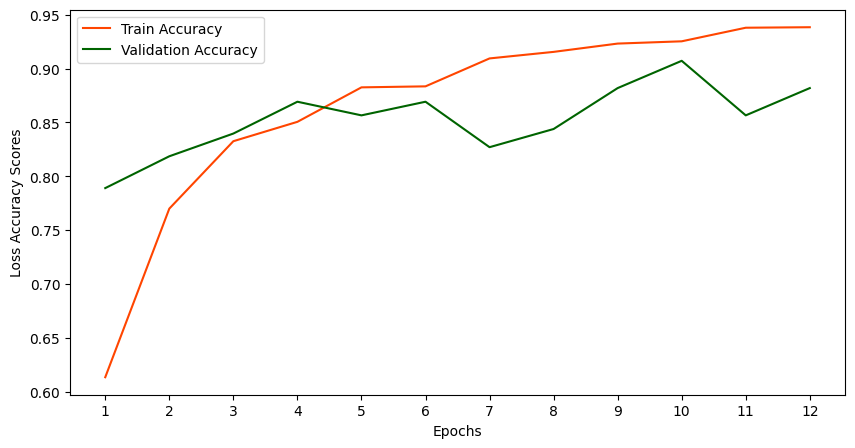

In [ ]:
def learning_curves(tr_losses, val_losses, tr_accs, val_accs):

    plt.figure(figsize = (10, 5))
    plt.plot(tr_losses, label = "Train Loss", c = "red")
    plt.plot(val_losses, label = "Validation Loss", c = "blue")
    plt.xlabel("Epochs"); plt.ylabel("Loss Values")
    plt.xticks(ticks = np.arange(len(tr_losses)), labels = [i for i in range(1, len(tr_losses) + 1)])
    plt.legend(); plt.show()

    plt.figure(figsize = (10, 5))
    plt.plot(tr_accs, label = "Train Accuracy", c = "orangered")
    plt.plot(val_accs, label = "Validation Accuracy", c = "darkgreen")
    plt.xlabel("Epochs"); plt.ylabel("Loss Accuracy Scores")
    plt.xticks(ticks = np.arange(len(tr_accs)), labels = [i for i in range(1, len(tr_accs) + 1)])
    plt.legend(); plt.show()

learning_curves(tr_losses, val_losses, tr_accs, val_accs)

239it [00:19, 12.32it/s]


Accuracy of the model on the test data -> 0.900


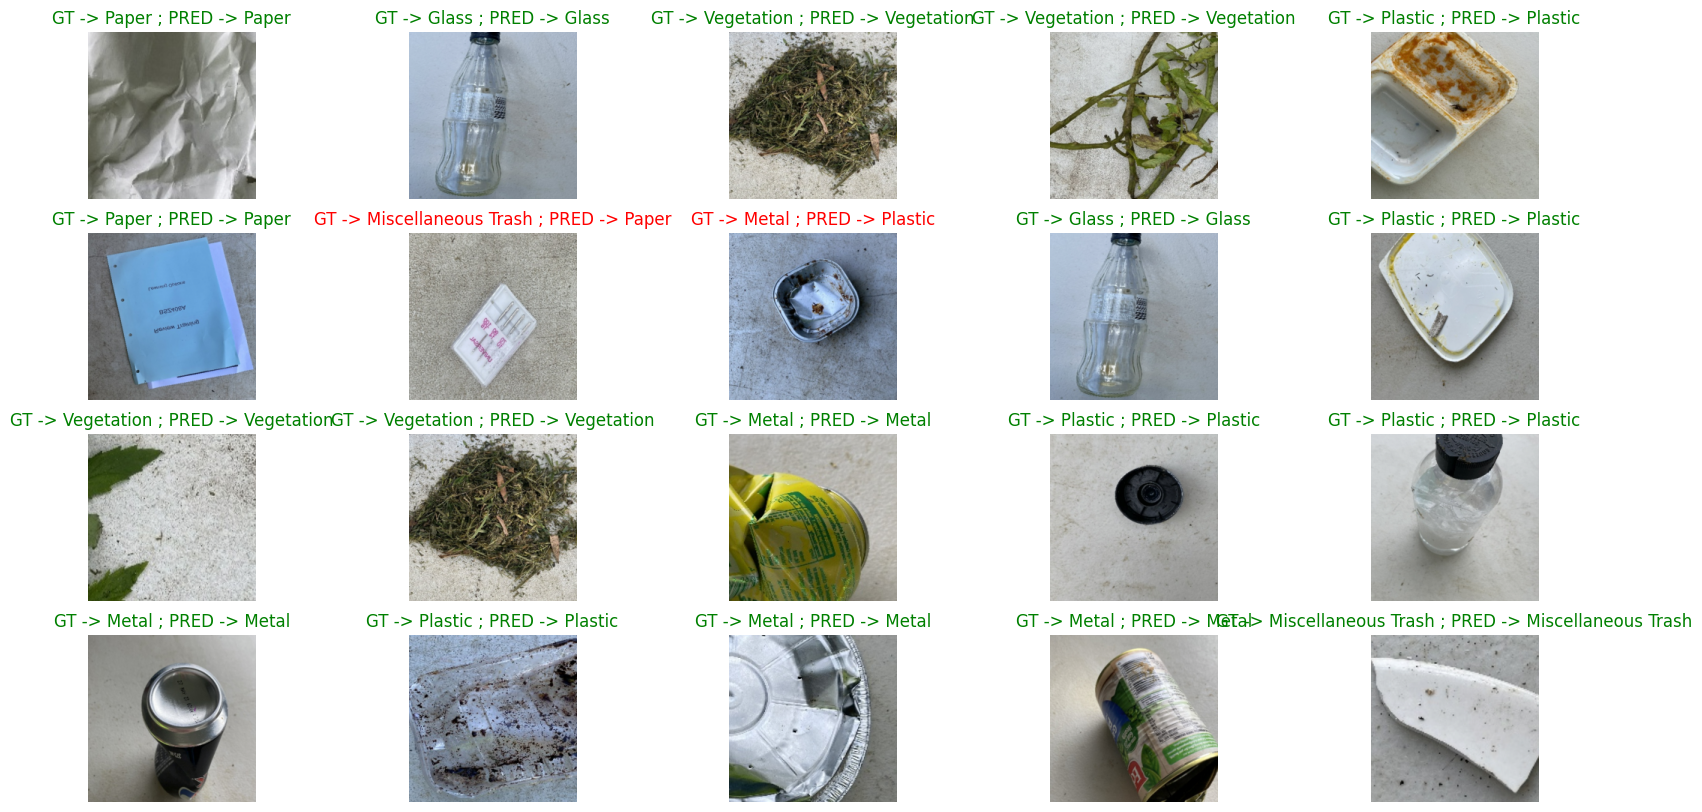

In [ ]:
import cv2

class SaveFeatures():

    """ Extract pretrained activations"""
    features = None
    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
        self.features = ((output.cpu()).data).numpy()
    def remove(self): self.hook.remove()

def getCAM(conv_fs, linear_weights, class_idx):

    bs, chs, h, w = conv_fs.shape
    cam = linear_weights[class_idx].dot(conv_fs[0,:, :, ].reshape((chs, h * w)))
    cam = cam.reshape(h, w)

    return (cam - np.min(cam)) / np.max(cam)

def inference(model, device, test_dl, num_ims, row, final_conv, fc_params, cls_names = None):

    weight, acc = np.squeeze(fc_params[0].cpu().data.numpy()), 0
    activated_features = SaveFeatures(final_conv)
    preds, images, lbls = [], [], []
    for idx, batch in tqdm(enumerate(test_dl)):
        im, gt = to_device(batch, device)
        pred_class = torch.argmax(model(im), dim = 1)
        acc += (pred_class == gt).sum().item()
        images.append(im)
        preds.append(pred_class.item())
        lbls.append(gt.item())

    print(f"Accuracy of the model on the test data -> {(acc / len(test_dl.dataset)):.3f}")

    plt.figure(figsize = (20, 10))
    indekslar = [random.randint(0, len(images) - 1) for _ in range(num_ims)]

    for idx, indeks in enumerate(indekslar):

        im = images[indeks].squeeze()
        pred_idx = preds[indeks]
        heatmap = getCAM(activated_features.features, weight, pred_idx)

        # Start plot
        plt.subplot(row, num_ims // row, idx + 1)
        plt.imshow(tensor_2_im(im), cmap = "gray"); plt.axis("off")

        if cls_names is not None: plt.title(f"GT -> {cls_names[int(lbls[indeks])]} ; PRED -> {cls_names[int(preds[indeks])]}", color=("green" if {cls_names[int(lbls[indeks])]} == {cls_names[int(preds[indeks])]} else "red"))
        else: plt.title(f"GT -> {gt} ; PRED -> {pred}")

m.load_state_dict(torch.load(f"{save_dir}/{save_prefix}_best_model.pth"))
m.eval()
final_conv, fc_params = m.features[-1], list(m.head.fc.parameters())
inference(model = m.to(device), device = device, test_dl = ts_dl, num_ims = 20, row = 4, cls_names = list(classes.keys()), final_conv = final_conv, fc_params = fc_params)